In [4]:
import os
import pydicom
import numpy as np
import pandas as pd
import cv2
from pydicom.pixel_data_handlers.util import apply_voi_lut

# ---------------------- Configuración de Rutas ---------------------- #

# Rutas a las carpetas y archivos CSV
csv_path = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/csv/filtered_with_image_names.csv'
source_images_dir = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/subset_datos/Images_Mass_Calc'
output_root = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/subset_datos/Images_Mass_Calc_PNG'

# Ruta para guardar el nuevo CSV
csv_output_path = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/csv/png_masasycalcificaciones.csv'

# ---------------------- Crear Estructura de Directorios ---------------------- #

def create_output_directories(output_root):
    categories = ['masas', 'calcificaciones']
    birads_subcategories = {
        'benigno': ['BI-RADS 3'],
        'sospechoso': ['BI-RADS 4'],
        'maligno': ['BI-RADS 5']
    }

    for category in categories:
        for subcategory, birads_list in birads_subcategories.items():
            for birads in birads_list:
                path = os.path.join(output_root, category, subcategory)
                os.makedirs(path, exist_ok=True)
                print(f"Creada o verificada la carpeta: {path}")

create_output_directories(output_root)

# ---------------------- Funciones de Procesamiento ---------------------- #

# Función para mapear BIRADS a subcategorías
def map_birads_to_subcategory(birads):
    if birads == 'BI-RADS 3':
        return 'benigno'
    elif birads == 'BI-RADS 4':
        return 'sospechoso'
    elif birads == 'BI-RADS 5':
        return 'maligno'
    else:
        print(f"Advertencia: BIRADS desconocido '{birads}'. Asignando a 'benigno'.")
        return 'benigno'

# Función para procesar y convertir DICOM a PNG
def dicom_to_png(dicom_path, image_name):
    try:
        dicom = pydicom.dcmread(dicom_path)
        original_image = dicom.pixel_array

        # Aplicar VOI LUT con prefer_lut=True (priorizando LUT si está presente)
        img_windowed = apply_voi_lut(original_image, dicom, prefer_lut=True)

        # Manejar Photometric Interpretation si es MONOCHROME1 (invertir la imagen)
        photometric_interpretation = dicom.get('PhotometricInterpretation', 'UNKNOWN')
        if photometric_interpretation == 'MONOCHROME1':
            img_windowed = img_windowed.max() - img_windowed
            print(f"Imagen '{image_name}' invertida debido a Photometric Interpretation: {photometric_interpretation}")
        else:
            print(f"Imagen '{image_name}' Photometric Interpretation: {photometric_interpretation}")

        # Normalizar la imagen para que esté en el rango [0, 255]
        img_normalized = (img_windowed - img_windowed.min()) / (img_windowed.max() - img_windowed.min()) * 255
        img_normalized = img_normalized.astype(np.uint8)

        # Redimensionar la imagen a 224x224 píxeles
        img_resized = cv2.resize(img_normalized, (224, 224), interpolation=cv2.INTER_AREA)

        return img_resized

    except Exception as e:
        print(f"Error al procesar {dicom_path}: {e}")
        return None

# Función para obtener la ruta del archivo DICOM usando image_id
def get_dicom_path(image_id, source_dir):
    # Posibles extensiones de archivo
    extensions = ['.dicom', '.dcm']
    for ext in extensions:
        dicom_filename = f"{image_id}{ext}"
        dicom_path = os.path.join(source_dir, dicom_filename)
        if os.path.exists(dicom_path):
            print(f"Encontrado DICOM para '{image_id}': {dicom_path}")
            return dicom_path
    # Si no se encuentra en la raíz, buscar en subdirectorios
    for root, dirs, files in os.walk(source_dir):
        for ext in extensions:
            dicom_filename = f"{image_id}{ext}"
            if dicom_filename in files:
                found_path = os.path.join(root, dicom_filename)
                print(f"Encontrado DICOM para '{image_id}' en subdirectorio: {found_path}")
                return found_path
    print(f"No se encontró el archivo DICOM para image_id: {image_id}")
    return None

# ---------------------- Procesamiento Principal ---------------------- #

def process_dicom_images(csv_path, source_dir, output_root, csv_output_path):
    # Leer el archivo CSV
    try:
        df = pd.read_csv(csv_path)
        print(f"CSV cargado correctamente con {len(df)} filas.")
    except Exception as e:
        print(f"Error al leer el CSV: {e}")
        return

    # Verificar columnas necesarias
    required_columns = ['image_id', 'image_name', 'finding_categories', 'finding_birads']
    for col in required_columns:
        if col not in df.columns:
            print(f"Error: La columna '{col}' no está presente en el CSV.")
            return

    # Limpiar los valores de 'finding_categories'
    df['finding_categories'] = df['finding_categories'].apply(lambda x: x.strip("[]'") if isinstance(x, str) else x)

    # Limpiar los valores de 'finding_birads' eliminando espacios adicionales
    df['finding_birads'] = df['finding_birads'].apply(lambda x: x.strip() if isinstance(x, str) else x)

    # Mostrar los valores únicos después de limpiar
    print("\nValores únicos en 'finding_categories' después de limpiar:")
    unique_categories = df['finding_categories'].unique()
    for category in unique_categories:
        print(f"- {category}")

    # Filtrar solo las categorías que contienen 'Mass' o 'Suspicious Calcification'
    # Considerando que 'finding_categories' puede tener múltiples categorías separadas por comas
    df_filtered = df[df['finding_categories'].str.contains(r'\bMass\b|\bSuspicious Calcification\b', case=False, na=False)]
    filtered_count = len(df_filtered)
    print(f"\nFiltrado de categorías 'Mass' y 'Suspicious Calcification': {filtered_count} de {len(df)} imágenes.")

    if filtered_count == 0:
        print("No hay imágenes para procesar después del filtrado.")
        return

    # NOTA: Ya no eliminamos duplicados basados en 'image_id'

    # Inicializar un diccionario para contar imágenes por categoría y subcategoría
    counts_dict = {
        'masas': {'benigno': 0, 'sospechoso': 0, 'maligno': 0},
        'calcificaciones': {'benigno': 0, 'sospechoso': 0, 'maligno': 0}
    }

    # Lista para almacenar las filas del nuevo CSV
    new_csv_data = []

    # Contador de imágenes procesadas y errores
    processed_images = 0
    failed_images = 0

    # Implementar una caché para almacenar dicom_path ya encontrados
    dicom_cache = {}

    # Recorrer cada fila del DataFrame filtrado
    for index, row in df_filtered.iterrows():
        image_id = row['image_id']
        image_name = row['image_name']
        finding_category = row['finding_categories']
        finding_birads = row['finding_birads']

        print(f"\nProcesando image_name: {image_name}, Categoría: {finding_category}, BIRADS: {finding_birads}")

        # Obtener la ruta del archivo DICOM usando image_id
        if image_id in dicom_cache:
            dicom_path = dicom_cache[image_id]
            if dicom_path is None:
                print(f"No se encontró previamente el DICOM para image_id: {image_id}. Saltando.")
                failed_images += 1
                continue
        else:
            dicom_path = get_dicom_path(image_id, source_dir)
            dicom_cache[image_id] = dicom_path

        if dicom_path is None:
            failed_images += 1
            continue  # Saltar si no se encontró el DICOM

        # Procesar la imagen DICOM y obtener la imagen normalizada y redimensionada
        img_png = dicom_to_png(dicom_path, image_name)
        if img_png is None:
            failed_images += 1
            continue  # Saltar si hubo un error en el procesamiento

        # Determinar la categoría y subcategoría
        if 'Mass' in finding_category or 'mass' in finding_category:
            category = 'masas'
        elif 'Suspicious Calcification' in finding_category or 'suspicious calcification' in finding_category:
            category = 'calcificaciones'
        else:
            print(f"Categoría desconocida '{finding_category}' para image_name {image_name}. Saltando.")
            failed_images += 1
            continue

        subcategory = map_birads_to_subcategory(finding_birads)

        # Incrementar el conteo correspondiente
        if category in counts_dict and subcategory in counts_dict[category]:
            counts_dict[category][subcategory] += 1
        else:
            # Si por alguna razón la categoría o subcategoría no existe en el diccionario
            print(f"Categoría o subcategoría no reconocida para image_name {image_name}.")
            failed_images += 1
            continue

        # Definir la ruta de guardado
        output_dir = os.path.join(output_root, category, subcategory)
        output_filename = f"{image_name}.png"
        output_path = os.path.join(output_dir, output_filename)

        # Guardar la imagen como PNG
        try:
            cv2.imwrite(output_path, img_png)
            print(f"Imagen PNG guardada en: {output_path}")
            processed_images += 1
        except Exception as e:
            print(f"Error al guardar PNG para {image_name}: {e}")
            failed_images += 1
            continue

        # Agregar la información al nuevo CSV
        new_csv_data.append({
            'image_name': image_name,
            'finding_birads': finding_birads,
            'finding_categories': finding_category
        })

    # Crear un DataFrame para el nuevo CSV
    new_csv_df = pd.DataFrame(new_csv_data)

    # Guardar el nuevo CSV
    try:
        new_csv_df.to_csv(csv_output_path, index=False)
        print(f"\nNuevo CSV guardado en: {csv_output_path}")
    except Exception as e:
        print(f"Error al guardar el nuevo CSV: {e}")

    # Mostrar los conteos
    print("\nCantidad de imágenes por categoría y subcategoría:")
    for category, subcats in counts_dict.items():
        for subcat, count in subcats.items():
            print(f"- {category.capitalize()} / {subcat.capitalize()}: {count}")
    total_processed = processed_images
    print(f"\nTotal de imágenes procesadas: {total_processed}")
    print(f"Total de imágenes fallidas: {failed_images}")

# ---------------------- Función de Procesamiento Manual ---------------------- #

def manual_process_single_image(image_id, image_name, source_dir, output_root):
    dicom_path = get_dicom_path(image_id, source_dir)
    if dicom_path:
        img_png = dicom_to_png(dicom_path, image_name)
        if img_png is not None:
            # Definir la categoría y subcategoría según tus datos
            finding_category = 'Mass'  # o 'Suspicious Calcification'
            finding_birads = 'BI-RADS 3'  # o 'BI-RADS 4', 'BI-RADS 5'

            if 'Mass' in finding_category or 'mass' in finding_category:
                category = 'masas'
            elif 'Suspicious Calcification' in finding_category or 'suspicious calcification' in finding_category:
                category = 'calcificaciones'
            else:
                print(f"Categoría desconocida '{finding_category}' para image_name {image_name}.")
                return

            subcategory = map_birads_to_subcategory(finding_birads)
            output_dir = os.path.join(output_root, category, subcategory)
            output_filename = f"{image_name}.png"
            output_path = os.path.join(output_dir, output_filename)

            # Guardar la imagen como PNG
            try:
                cv2.imwrite(output_path, img_png)
                print(f"Imagen PNG guardada manualmente en: {output_path}")
            except Exception as e:
                print(f"Error al guardar PNG para {image_name}: {e}")
        else:
            print(f"No se pudo procesar la imagen DICOM para {image_name}.")
    else:
        print(f"No se encontró el archivo DICOM para image_id: {image_id}.")

# ---------------------- Ejecutar el Procesamiento ---------------------- #

if __name__ == "__main__":
    # Ejecutar el procesamiento principal
    process_dicom_images(csv_path, source_images_dir, output_root, csv_output_path)

    # Opcional: Ejecutar el procesamiento manual de una sola imagen para verificar
    # Descomenta las siguientes líneas y reemplaza 'ejemplo_image_id' y 'ejemplo_image_name' con valores válidos
    # manual_process_single_image('ffb94da823c87898c7ce19b197dc24c9', 'ffb94da823c87898c7ce19b197dc24c9_0', source_images_dir, output_root)


Creada o verificada la carpeta: /Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/subset_datos/Images_Mass_Calc_PNG/masas/benigno
Creada o verificada la carpeta: /Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/subset_datos/Images_Mass_Calc_PNG/masas/sospechoso
Creada o verificada la carpeta: /Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/subset_datos/Images_Mass_Calc_PNG/masas/maligno
Creada o verificada la carpeta: /Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/subset_datos/Images_Mass_Calc_PNG/calcificaciones/benigno
Creada o verificada la carpeta: /Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/subset_datos/Images_Mass_Calc_PNG/calcificaciones/sospechoso
Creada o verificada la carpeta: /Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/subset_datos/Images_Mass_Calc_PNG/calcificaciones/maligno
CSV cargado correctamente con 1525 filas.

Valores únicos en 'fi

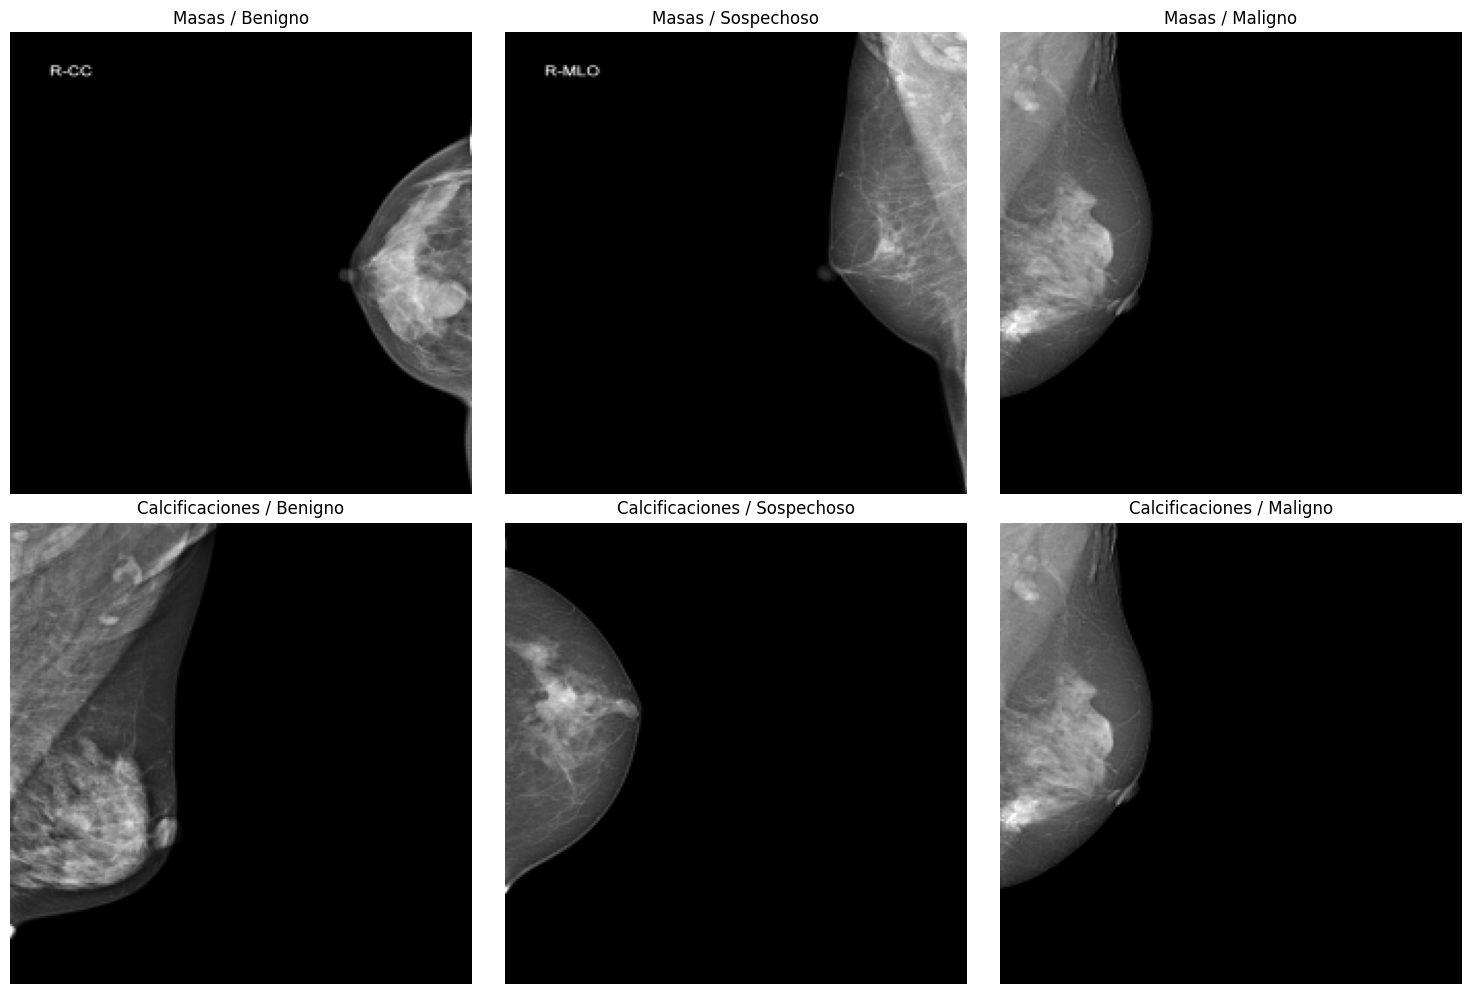

In [5]:
import os
import matplotlib.pyplot as plt
import cv2
import glob

# ---------------------- Configuración de Rutas ---------------------- #

# Ruta a la carpeta raíz donde se almacenan las imágenes PNG procesadas
output_root = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/subset_datos/Images_Mass_Calc_PNG'

# Categorías y subcategorías
categories = {
    'masas': ['benigno', 'sospechoso', 'maligno'],
    'calcificaciones': ['benigno', 'sospechoso', 'maligno']
}

# ---------------------- Función para Seleccionar una Imagen ---------------------- #

def select_one_image(category, subcategory):
    """
    Selecciona la primera imagen PNG encontrada en la carpeta especificada.
    """
    # Construir la ruta de la subcategoría
    subcategory_path = os.path.join(output_root, category, subcategory)
    
    # Buscar archivos PNG en la carpeta
    png_files = glob.glob(os.path.join(subcategory_path, '*.png'))
    
    if png_files:
        return png_files[0]  # Retorna la primera imagen encontrada
    else:
        print(f"No se encontraron imágenes en {subcategory_path}")
        return None

# ---------------------- Visualización de Imágenes ---------------------- #

def visualize_images(categories):
    """
    Visualiza una imagen de cada combinación de categoría y subcategoría.
    """
    # Calcular el número total de subcategorías para la cuadrícula
    total_images = sum(len(subcats) for subcats in categories.values())
    
    # Configurar la figura de Matplotlib
    cols = 3  # Número de columnas en la cuadrícula
    rows = (total_images + cols - 1) // cols  # Calcular el número de filas necesarias
    
    plt.figure(figsize=(15, 5 * rows))  # Ajustar el tamaño según el número de filas
    
    img_count = 1  # Contador de imágenes
    
    for category, subcategories in categories.items():
        for subcategory in subcategories:
            img_path = select_one_image(category, subcategory)
            if img_path:
                # Leer la imagen usando OpenCV
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    print(f"Error al leer la imagen: {img_path}")
                    continue
                
                # Mostrar la imagen en la cuadrícula
                plt.subplot(rows, cols, img_count)
                plt.imshow(img, cmap='gray')
                plt.title(f"{category.capitalize()} / {subcategory.capitalize()}")
                plt.axis('off')  # Ocultar los ejes
                img_count += 1
    
    plt.tight_layout()
    plt.show()

# ---------------------- Ejecutar la Visualización ---------------------- #

if __name__ == "__main__":
    visualize_images(categories)
